## Vanilla GAN on CIFAR-10 Dataset
* Goutham Krishnan - 21BAI1007

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.variable import Variable
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import imageio
from torchvision.transforms.functional import to_pil_image


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = CIFAR10(root='./data/', train=True, download=True, transform = transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 76135866.18it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/


In [3]:
train_features_batch, train_labels_batch = next(iter(trainloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([100, 3, 32, 32]), torch.Size([100]))

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda')

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 3072
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_features, 256),
                    nn.LeakyReLU(0.2)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(256, 512),
                    nn.LeakyReLU(0.2)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 1024),
                    nn.LeakyReLU(0.2)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(1024, self.n_out),
                    nn.Tanh()
                    )
    def forward(self, x):
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.view(-1, 3, 32, 32)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 3072
        self.n_out = 1
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_in, 1024),
                    nn.LeakyReLU(0.2),
                    #nn.Dropout(0.3)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 256),
                    nn.LeakyReLU(0.2),
                    #nn.Dropout(0.3)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(256, self.n_out),
                    nn.Sigmoid()
                    )
    def forward(self, x):
        x = x.view(-1, 3072)
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

g_losses = []
d_losses = []
images = []

criterion = nn.BCELoss()

def noise(n, n_features=128):
    return Variable(torch.randn(n, n_features)).to(device)

def make_ones(size):
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def make_zeros(size):
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)

    optimizer.zero_grad()

    prediction_real = discriminator(real_data)
    error_real = criterion(prediction_real, make_ones(n))
    error_real.backward()

    prediction_fake = discriminator(fake_data)
    error_fake = criterion(prediction_fake, make_zeros(n))

    error_fake.backward()
    optimizer.step()

    return error_real + error_fake

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()

    prediction = discriminator(fake_data)
    error = criterion(prediction, make_ones(n))

    error.backward()
    optimizer.step()

    return error

num_epochs = 30
k = 1
test_noise = noise(64)

generator.train()
discriminator.train()
for epoch in range(num_epochs):
    g_error = 0.0
    d_error = 0.0
    for i, data in enumerate(trainloader):
        imgs, _ = data
        n = len(imgs)
        for j in range(k):
            fake_data = generator(noise(n)).detach()
            real_data = imgs.to(device)
            d_error += train_discriminator(d_optim, real_data, fake_data)
        fake_data = generator(noise(n))
        g_error += train_generator(g_optim, fake_data)

    img = generator(test_noise).cpu().detach()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_error/i)
    d_losses.append(d_error/i)
    print('Epoch {}: g_loss: {:.8f} d_loss: {:.8f}\r'.format(epoch, g_error/i, d_error/i))

print('Training Finished')
torch.save(generator.state_dict(), 'mnist_generator.pth')

def to_image(tensor):
    """Converts a PyTorch tensor to a PIL Image."""
    return to_pil_image(tensor)

import numpy as np
from matplotlib import pyplot as plt
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('progress.gif', imgs)



Epoch 0: g_loss: 2.23442745 d_loss: 0.82479674
Epoch 1: g_loss: 3.13400316 d_loss: 0.55228484
Epoch 2: g_loss: 3.30379939 d_loss: 0.51121032
Epoch 3: g_loss: 3.73324966 d_loss: 0.52094626
Epoch 4: g_loss: 4.21040583 d_loss: 0.47892100
Epoch 5: g_loss: 3.02885246 d_loss: 0.55072361
Epoch 6: g_loss: 2.50914526 d_loss: 0.63632798
Epoch 7: g_loss: 2.80670810 d_loss: 0.62263358
Epoch 8: g_loss: 2.69110155 d_loss: 0.61790401
Epoch 9: g_loss: 2.60561609 d_loss: 0.65220708
Epoch 10: g_loss: 2.28687501 d_loss: 0.67567670
Epoch 11: g_loss: 2.28377676 d_loss: 0.71969235
Epoch 12: g_loss: 1.99844444 d_loss: 0.79921025
Epoch 13: g_loss: 1.96393502 d_loss: 0.82091039
Epoch 14: g_loss: 1.82680023 d_loss: 0.88273793
Epoch 15: g_loss: 1.73634279 d_loss: 0.92560983
Epoch 16: g_loss: 1.77444279 d_loss: 0.90220356
Epoch 17: g_loss: 1.83142126 d_loss: 0.88866836
Epoch 18: g_loss: 1.74795461 d_loss: 0.88514179
Epoch 19: g_loss: 1.67497253 d_loss: 0.91695046
Epoch 20: g_loss: 1.54414332 d_loss: 0.95897782
Ep

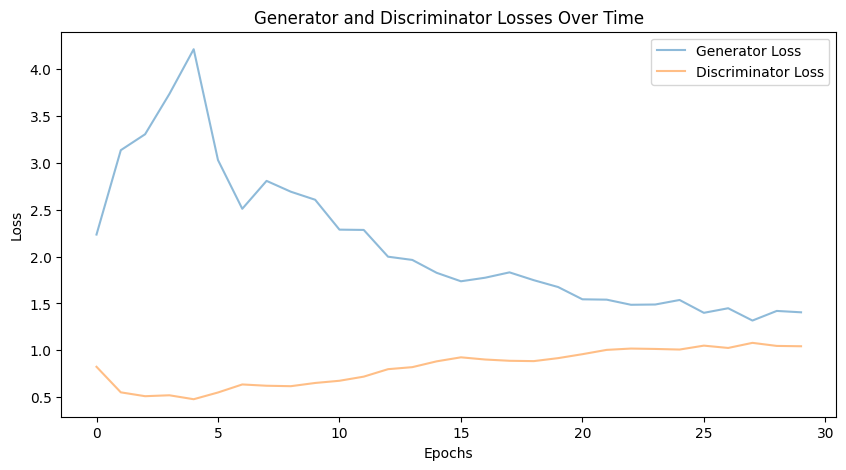

In [7]:
import matplotlib.pyplot as plt

g_losses_cpu = [loss.cpu().item() for loss in g_losses]
d_losses_cpu = [loss.cpu().item() for loss in d_losses]
plt.figure(figsize=(10, 5))
plt.plot(g_losses_cpu, label='Generator Loss', alpha=0.5)
plt.plot(d_losses_cpu, label='Discriminator Loss', alpha=0.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses Over Time')
plt.legend()
plt.show()